# Make the raw CSVs into a dataset

In [145]:
# imports
import pandas as pd
import numpy as np
import os
import scipy
from scipy import stats
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', None)

Flow for generation of dataset

1. Generate average IgE standard curve per batch
2. Minus each membrane by the batch blank (Does this belong here?)
3. Scale each membrane up to the average PBS value
4. Minus the absorbance value of each membrane by the respective blank (if we already minus by the batch blank, do we even still need to minus by the respective blank? Should clarify with Prof)
5. Approximate sIgE level from absorbance based on average IgE standard curve
6. Create final dataset

## 1. Generate average IgE standard curve and average PBS

- Get the average of all the different IgE standards
- Get the average of all the PBS
- Minus the PBS value from all the IgE standards
- Plot log curve

In [146]:
# Set directory of batch
batch_directory = "120322"

panel1 = pd.read_excel("First Stage Combine/1-full-combine.xlsx")
panel2 = pd.read_excel("First Stage Combine/2-full-combine.xlsx")


# Get the IgE values
panel1_ige = panel1.iloc[:,9:18]
panel2_ige = panel2.iloc[:,9:18]
# Make column names the same
panel1_ige.set_axis([i for i in range(9)], axis=1, inplace=True)
panel2_ige.set_axis([i for i in range(9)], axis=1, inplace=True)
combine_ige = pd.concat([panel1_ige, panel2_ige])

# Get average PBS values (index 6)
pbs_1 = panel1.iloc[:,6]
pbs_2 = panel2.iloc[:,6]
combine_pbs = pd.concat([pbs_1, pbs_2])

Plot the IgE standard curve and estimate with trendline and R2 value

- For now it seems the best fit is a linear curve

Equation: y = 116.8167580214387*x + 15848.880388024187
R2: 0.7755463041390904


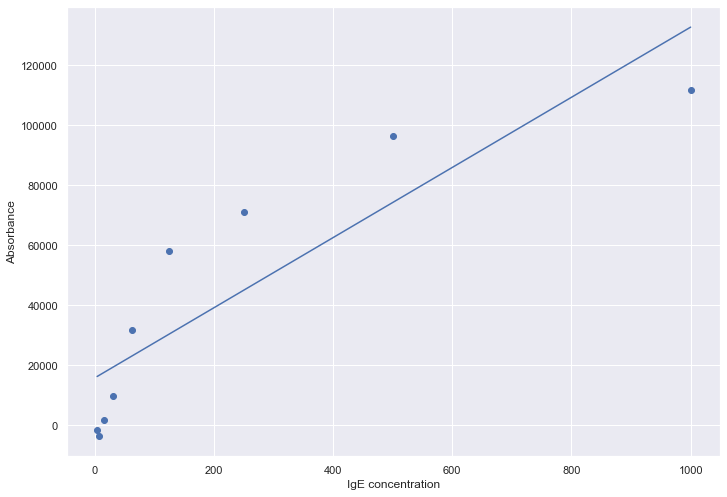

In [147]:
# Test new IgE curve
ige = combine_ige.mean(axis=0) - combine_pbs.mean(axis=0)

ige_level = np.array([1000.0 / 2**i for i in range(9)])
x = ige_level

# Plot scatterplot
plt.scatter(ige_level, ige)

# Add trendline
degree = 1
# m, b = np.polyfit(ige_level, ige, degree)
m, b, r, p_value, se = stats.linregress(ige_level, ige)
plt.plot(x, m*x + b)

plt.xlabel("IgE concentration")
plt.ylabel("Absorbance")

# Print equation and R2
print(f"Equation: y = {m}*x + {b}")
print(f"R2: {r ** 2}")

In [ ]:
ige

In [ ]:
combine_ige.mean(axis=0)

Equation: y = 0.0066389986956902096*x + -55.43951628286908
R2: 0.7755463041390904


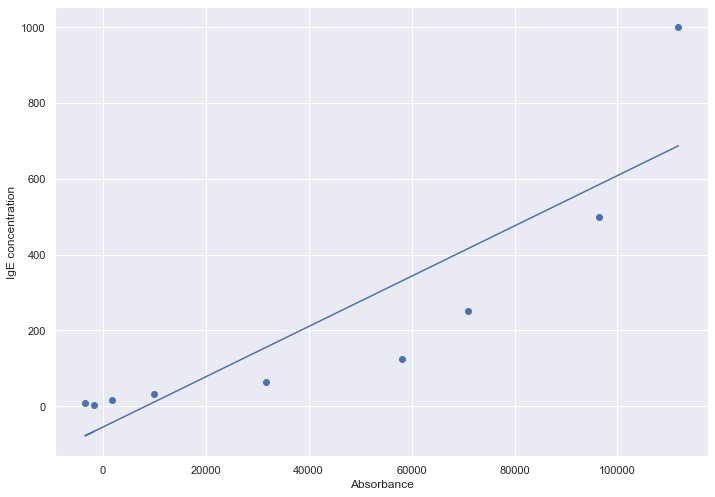

In [148]:
# Plot curve to get x in terms of y
# Plot scatterplot
plt.scatter(ige, ige_level)

# Add trendline
degree = 1
# m, b = np.polyfit(ige, ige_level, degree)
m, b, r, p_value, se = stats.linregress(ige, ige_level)
plt.plot(ige, m*ige + b)

plt.ylabel("IgE concentration")
plt.xlabel("Absorbance")

# Print equation and R2
print(f"Equation: y = {m}*x + {b}")
print(f"R2: {r ** 2}")

## 2. Scale each membrane up to the average PBS value

In [149]:
# Choose panel/batch/all
avg_pbs = combine_pbs.mean(axis=0)

# Scale them up by panel (since their number of allergens are different)
# For panel 1
for index, row in panel1.iterrows():
    panel_pbs = row[3]
    scalar = avg_pbs / panel_pbs
    panel1.iloc[index,3:] *= scalar

# For panel 2
for index, row in panel2.iterrows():
    panel_pbs = row[3]
    scalar = avg_pbs / panel_pbs
    panel2.iloc[index,3:] *= scalar

In [150]:
panel1.head()

,ID,Panel,Batch,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135
0,30,1,150222-CSV,261588.884606,259486.632576,264084.568245,262826.061111,248242.072787,249084.869655,331897.009162,291186.317927,279296.625102,261039.502396,239581.837252,239547.708245,247755.734437,250272.748705,255417.222501,266466.014514,270221.627329,276997.183253,253329.190890,241825.819465,265648.814401,254612.820766,252239.432735,237738.870873,235708.194954,228720.280764,237380.516299,231032.520991,235639.936940,235179.195345,241689.303437,245477.623217,251714.699252,253540.601128,260987.360857,268603.817593,246510.025680,239735.417784,244832.490181,236757.661921,230529.118137,224471.219389,224573.606410,221314.286239,268622.778153,270138.200868,231971.068684,236663.807151,237167.210005,243148.318487,249197.684984,254158.715367,258139.010812,264983.772778,251681.044259,267941.146040,246492.961176,226800.524119,224326.171109,219112.965285,220699.964112,217048.160360,229445.522164,230998.391984,235051.211569,239820.740302,244342.833733,240196.159379,246424.703162,249624.297572,257840.382001,264523.505197,251569.650972,237320.790537,225392.702579,215631.806568,215665.935575,218276.804613,221792.092337,222252.833932,229206.619115,234163.857386,238813.934594,240341.207659,240981.126541,244223.382209,246484.428925,250085.039167,258859.512072,267457.177760,245904.235805,229667.360710,220665.835105,216374.112471,219010.578264,223805.703752,227559.894525,233924.954337,238088.693195,240503.320442,243958.882404,245707.994015,249001.443193,248079.960003,249658.426579,255326.211816,260953.705864,272314.873094,248455.379081,237508.500075,234573.405470,230307.279591,233063.196909,235153.598590,238916.321615,242764.367158,244086.866181,247021.960785,250466.620426,250475.152677,251125.973881,252525.263169,256052.875257,258804.526449,266057.888471,274535.154607,258493.099260,256012.110054,250973.815391,251188.543727,251655.447504,252835.742330,252513.886834,253987.596318,258271.734728,258902.647344
1,5,1,150222-CSV,268500.347801,264117.557807,263051.035686,262826.061111,238771.286801,235411.580034,331455.625011,281010.101192,258713.629613,237302.144475,231017.119890,226229.764666,224520.735905,222934.892070,224455.253392,234234.191480,240765.585916,255600.292697,264061.152078,251373.104716,245027.784351,232389.010959,231238.204414,211139.611249,224882.510582,224118.115700,230584.675966,218983.249318,216793.151004,195280.524559,211959.115177,212693.686340,213262.282024,223939.821729,238572.245895,251995.512762,256664.221452,240852.463706,239559.670327,231810.041807,229623.833544,204064.906455,223296.018406,219480.527413,270235.958572,274026.812579,201335.387835,198257.709714,204781.324050,216790.557637,216449.529895,226369.158135,240584.050236,254459.211279,260407.098172,243410.820114,243085.352573,237292.419349,232175.058193,212883.650463,214431.242136,205840.066071,198788.053237,195098.988879,198448.322178,204241.255402,210759.034663,222308.593974,231708.252158,238950.229114,246485.256526,256787.406378,262788.457292,244087.688864,243889.944641,237098.565176,227913.508100,218706.407405,213054.164334,207192.506888,194710.632191,199767.697568,209809.862392,213668.143938,222409.086940,228928.811226,239295.795249,244448.815199,255063.465757,263591.752677,267716.502667,249417.706103,240897.199285,230998.966322,227873.310914,220941.889639,224906.499226,219122.642786,218996.216152,221373.036879,224097.368765,227407.153221,236458.651904,237431.164476,240886.177475,249356.113640,256503.432706,268327.888905,268881.572729,254029.360722,245138.002442,230431.018979,237848.696541,236158.469690,241487.838587,2

In [ ]:
# Export to compile for Prof Chew
panel1.to_csv("Excel analysis/No norm, average IgE/linear_scaled/scale2pbs_panel1.csv", index=False)
panel2.to_csv("Excel analysis/No norm, average IgE/linear_scaled/scale2pbs_panel2.csv", index=False)

## 3. Minus each membrane by batch blank 

Test out in removing edge effect. Theoretically should not remove it, but should definitely reduce it

In [ ]:
len(panel1["ID"].unique())

In [ ]:
# Try on panel 1
batchsub1 = panel1.copy(deep=True)
# tosub = panel1.loc[(panel1["ID"] == "B") & (panel1["Batch"] == 120322)]

# Split into separate batches and then minus by batch
list_of_batches = []
for batch in panel1["Batch"].unique():
    batch_df = panel1.loc[panel1["Batch"] == batch]
    batch_blank = panel1.loc[(panel1["ID"] == "B") & (panel1["Batch"] == batch)]
    # Remove first 3 columns
    batch_sub = pd.DataFrame(batch_df.iloc[:,3:].values - batch_blank.iloc[:,3:].values, columns=batch_df.iloc[:,3:].columns)
    # Add back first 3 columns
    # batch_sub.insert(0, "Batch", batch_df["Batch"])
    # batch_sub.insert(0, "Panel", batch_df["Panel"])
    # batch_sub.insert(0, "ID", batch_df["ID"])
    list_of_batches.append(batch_sub)

In [ ]:
rb1 = pd.concat(list_of_batches)
rb1.shape

In [ ]:
batchsub2 = panel2.copy(deep=True)
# tosub = panel2.loc[(panel2["ID"] == "B") & (panel2["Batch"] == 120322)]

# Split into separate batches and then minus by batch
list_of_batches = []
for batch in panel2["Batch"].unique():
    batch_df = panel2.loc[panel2["Batch"] == batch]
    batch_blank = panel2.loc[(panel2["ID"] == "B") & (panel2["Batch"] == batch)]
    # Remove first 3 columns
    batch_sub = pd.DataFrame(batch_df.iloc[:,3:].values - batch_blank.iloc[:,3:].values, columns=batch_df.iloc[:,3:].columns)
    # Add back first 3 columns
    # batch_sub.insert(0, "Batch", batch_df["Batch"])
    # batch_sub.insert(0, "Panel", batch_df["Panel"])
    # batch_sub.insert(0, "ID", batch_df["ID"])
    list_of_batches.append(batch_sub)

In [ ]:
rb2 = pd.concat(list_of_batches)
rb2.shape

### Below is outdated

In [ ]:
# Similarly, do by panel
subtracted1 = panel1.copy(deep=True).iloc[:,3:]
to_subtract1 = panel1.loc[panel1["ID"] == "B"].iloc[:,3:]
sub1 = pd.DataFrame(subtracted1.values - to_subtract1.values, columns=subtracted1.columns)

sub1.head()

In [ ]:
subtracted2 = panel2.copy(deep=True).iloc[:,3:]
to_subtract2 = panel2.loc[panel2["ID"] == "B"].iloc[:,3:]
sub2 = pd.DataFrame(subtracted2.values - to_subtract2.values, columns=subtracted2.columns)

sub2.head()

### New thing to try: account for edge effect (Skip if accounted for when combining)

Idea 1: Get a factor to multiply to the average PBS for each allergen
- This method helps for some membranes, for some others, it has no effect

In [ ]:
# Test out with panel 1 first
edge1_df = panel1[panel1["ID"] == "B"].iloc[:,3:]
edge2_df = panel2[panel2["ID"] == "B"].iloc[:,3:]

# Scale down or up to average PBS value
# Record the scaling factors in a list
factors1 = []
factors2 = []

# Iterate through each column
for column in edge1_df:
    factor1 = edge1_df[column] / avg_pbs
    factors1.append(factor1)
for column in edge2_df:
    factor2 = edge2_df[column] / avg_pbs
    factors2.append(factor2)

plt.plot(factors2)

In [ ]:
# Idea 1.1 - take the average of the factors across the columns
# This means we will not account for difference between columns 
# (which is quite prevalent too)

def edge_factors(edge_df, avg_pbs):
    # Ignore first 18
    avg_factors = [[] for i in range(18)]
    factors = []

    # Start at 18
    i = 18
    end = edge_df.shape[1]
    edge = edge_df.values.tolist()[0]

    for row in range(8):
        # Ignore second row
        if row == 1:
            continue
        for col in range(18):
            # Break condition
            if i > end-1:
                break
            factor = edge[i] / avg_pbs
            factors.append(factor)
            avg_factors[col].append(factor)
            i += 1

    # Convert each sublist into average
    for i in range(len(avg_factors)):
        avg_factors[i] = sum(avg_factors[i]) / len(avg_factors[i])
        
    return avg_factors

In [ ]:
avg_factors1 = edge_factors(edge1_df, avg_pbs)
avg_factors2 = edge_factors(edge2_df, avg_pbs)
avg_factors2

In [ ]:
# Apply this factor to every element, in groups of 18 (even PBS)
edged1_df = panel1.copy(deep=True).iloc[:,3:]
edged2_df = panel1.copy(deep=True).iloc[:,3:]

for i in range(edged1_df.shape[1] - 1):
    factor = avg_factors1[i%18]
    edged1_df.iloc[:,i] /= factor
for i in range(edged2_df.shape[1] - 1):
    factor = avg_factors2[i%18]
    edged2_df.iloc[:,i] /= factor
    
edged1_df.head()

After accounting for edge effect, their average PBS values will be off the mark, so we should standardise that again

In [ ]:
for index, row in edged1_df.iterrows():
    panel_pbs = row[3]
    scalar = avg_pbs / panel_pbs
    edged1_df.iloc[index] *= scalar

# For panel 2
for index, row in edged2_df.iterrows():
    panel_pbs = row[3]
    scalar = avg_pbs / panel_pbs
    edged2_df.iloc[index] *= scalar
    
edged2_df.head()

In [ ]:
# Export
edged1_df.to_csv("Processing/edged1.csv", index=False)
edged2_df.to_csv("Processing/edged2.csv", index=False)

In [ ]:
# Updated IgE curve
# Get the IgE values
panel1_ige = edged1_df.iloc[:,6:15]
panel2_ige = edged2_df.iloc[:,6:15]
combine_ige = pd.concat([panel1_ige, panel2_ige])

ige = combine_ige.mean(axis=0) - combine_pbs.mean(axis=0)

ige_level = np.array([1000.0 / 2**i for i in range(9)])
x = ige_level

# Plot curve to get x in terms of y
# Plot scatterplot
plt.scatter(ige, ige_level)

# Add trendline
degree = 1
# m, b = np.polyfit(ige, ige_level, degree)
m, b, r, p_value, se = stats.linregress(ige, ige_level)
plt.plot(ige, m*ige + b)

plt.ylabel("IgE concentration")
plt.xlabel("Absorbance")

# Print equation and R2
print(f"Equation: y = {m}*x + {b}")
print(f"R2: {r ** 2}")

## 3.1. Minus each allergen by its respective blank

(To skip PBS scaling, just don't run that section before this)

In this method, we ignore the batch blank

- Dust mite allergens - BB w/o urea (2)
- All crudes (seafood or food) - PBS + glycerol (4)
- Recombinant insect protein - B B w or w/o urea gel (26/25)
- Minus for IgE too

In [151]:
rb1 = panel1.copy(deep=True).iloc[:,3:]
rb2 = panel2.copy(deep=True).iloc[:,3:]

print(rb1.shape)
print(rb2.shape)

(135, 136)
(135, 134)


In [152]:
# Dust mite allergens (do I even need to do it for the second panel LOL
rb1.iloc[:,15:20] = rb1.iloc[:,15:20].sub(rb1.iloc[:,2], axis=0)
rb2.iloc[:,15:20] = rb2.iloc[:,15:20].sub(rb2.iloc[:,2], axis=0)

# All crudes
# It is easy for panel 1. Panel 2 will have to do in 2 steps
rb1.iloc[:,20:] = rb1.iloc[:,20:].sub(rb1.iloc[:,4], axis=0)
rb2.iloc[:,20:25] = rb2.iloc[:,20:25].sub(rb2.iloc[:,4], axis=0) # Dust mite and cockroach
rb2.iloc[:,27:30] = rb2.iloc[:,27:30].sub(rb2.iloc[:,4], axis=0) # BSF P, PKM, M<P
rb2.iloc[:,35:] = rb2.iloc[:,35:].sub(rb2.iloc[:,4], axis=0)

# Recombinant insect protein. Tropomyosins should be w/o urea. AKs should be w urea
rb2.iloc[:,30:32] = rb2.iloc[:,30:32].sub(rb2.iloc[:,25], axis=0) # BSF Trop 1 and 2
rb2.iloc[:,32] = rb2.iloc[:,32].sub(rb2.iloc[:,26], axis=0) # BSF AK
rb2.iloc[:,33] = rb2.iloc[:,33].sub(rb2.iloc[:,25], axis=0) # TE Trop 1
rb2.iloc[:,34] = rb2.iloc[:,34].sub(rb2.iloc[:,26], axis=0) # AS AK

# IgE for rb1 (minus for individual PBS)
rb1.iloc[:,6:15] = rb1.iloc[:,6:15].sub(rb1.iloc[:,3], axis=0)
rb2.iloc[:,6:15] = rb2.iloc[:,6:15].sub(rb2.iloc[:,3], axis=0)

rb2.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133
0,354113.780446,285712.815200,264612.971504,262826.061111,263582.283901,256814.559414,118081.985641,82998.159683,75810.070666,23453.740612,35264.394914,679.661552,9561.487381,13402.550222,25377.883412,33511.431485,48047.954753,56136.721725,5756.538331,6874.621309,-7908.198016,-8779.262661,9263.187465,-25235.595074,-27704.333846,256849.950929,257962.977977,-18668.663267,-19024.022973,-26693.869966,8790.096799,14435.404652,22215.037571,31176.313741,44529.749206,48803.455267,-21518.041399,-33410.312869,6417.420711,7061.690748,15588.156870,13007.465345,23883.494728,35330.844290,3877.176632,-17401.791469,-29787.377328,-25229.816868,-30456.927018,-23861.826454,-18238.186875,-24597.103244,-16797.246603,-11154.105576,-2540.244079,-2621.138971,1869.249837,3348.470728,13713.851103,26859.271130,39559.769249,38196.834766,-7267.539358,-28716.964554,-30641.107354,-29235.558597,-31130.088088,-28856.363788,-19159.088553,-15491.371910,-6496.148776,-9476.981109,-1469.831305,182.735784,15161.291857,11935.608020,10329.988859,16524.226340,25596.732987,40693.742296,-15337.527159,29110.604879,-19086.860970,-12744.556944,5640.251923,-9746.389992,-3908.234493,-2291.781195,-3634.491955,-1391.825516,10894.808555,4535.892185,5537.688756,12589.267642,18706.943886,24306.748362,38857.717147,47873.886279,-726.609481,-11625.751690,-9902.401570,-5472.683931,-1087.025118,-67.893928,7825.136296,4877.528651,4662.290455,7165.698467,8624.695635,14171.051700,25367.049274,20161.607399,23830.768593,26988.558503,33960.687049,67989.990301,28272.042645,96883.912432,22126.919920,31835.029294,36031.451841,21105.621903,24529.931592,20270.671048,25047.803359,27398.811172,36221.410383,30197.629997,34453.279162,47358.181340,92858.669255,51176.131354,72039.790855,71542.865087
1,289176.657650,282273.455836,274466.448819,262826.061111,262420.907054,257808.383946,126287.503677,81338.367573,75796.614614,27410.230226,41429.872830,23514.518141,29015.263605,35934.048266,43631.975345,34905.580276,48836.646690,58311.018479,6311.053577,-15598.431186,-6092.893700,-22735.375725,-21036.845256,-27425.813074,-21800.404824,275167.676994,271645.953270,358.405512,-8835.475007,-19696.720299,2586.752824,4768.351591,14523.214651,19478.560422,33643.369561,53262.175618,-27675.138648,-35373.065726,15972.419546,19416.229029,20818.685379,28610.109548,35435.397120,48509.406875,-93.497090,-27192.070349,-24355.991952,-28251.704036,-26677.836354,-23109.364085,-8492.652344,-6420.133515,-5391.665525,545.399692,2726.998459,5407.248373,9474.371789,11500.142073,15489.351248,30963.119647,38100.064185,60118.628886,-6716.207633,-25322.128549,-22112.061791,-19057.823517,-6544.796302,-5142.339951,342.822663,3786.632146,5781.236733,7916.086955,7370.687264,16003.585243,15504.934096,18761.749398,27160.904652,33347.295442,51236.405334,71759.016595,6030.562307,-7261.607325,15.582848,-2306.261554,9349.709003,10440.508386,15520.516944,15598.431186,16268.493664,12544.192912,16813.893356,16003.585243,21909.484763,26475.259326,39720.680413,50940.331216,65510.294411,87468.988169,22579.547241,11624.804860,18154.018313,20584.942654,25415.625639,22844.455663,27799.801434,28189.372643,29809.988870,23841.757957,30854.039708,33986.192224,33300.546897,41107.553915,48571.738268,57111.139157,76662.692921,94728.135044,68008.471045,48696.401055,58304.457280,45720.077022,54212.729366,51392.233817,52950.518651,52872.604409,55958.008380,59651.143436,56581.322314,61193.845422,64403.912179,66351.768221,71368.625236,83252.597468,93433.938482,111635.525490
2,273651.260747,264405.332946,264962.898866,262826.061111,261770.472727

In [ ]:
# Export for Prof Chew
rb1.to_csv("Excel analysis/No norm, average IgE/batchsub_linear_scaled/1-full-pbs-minus.csv", index=False)
rb2.to_csv("Excel analysis/No norm, average IgE/batchsub_linear_scaled/2-full-pbs-minus.csv", index=False)

In [153]:
sub1 = rb1.copy(deep=True)
sub2 = rb2.copy(deep=True)

## 3.2 Test out minus only

No scaling of PBS

In [ ]:
minus1 = pd.read_csv("First Stage Combine/" + batch_directory + "/1-edge-combine.csv").iloc[:,3:]
minus2 = pd.read_csv("First Stage Combine/" + batch_directory + "/2-edge-combine.csv").iloc[:,3:]

# Dust mite allergens (do I even need to do it for the second panel LOL
minus1.iloc[:,15:20] = minus1.iloc[:,15:20].sub(minus1.iloc[:,2], axis=0)
minus2.iloc[:,15:20] = minus2.iloc[:,15:20].sub(minus2.iloc[:,2], axis=0)

# All crudes
# It is easy for panel 1. Panel 2 will have to do in 2 steps
minus1.iloc[:,20:] = minus1.iloc[:,20:].sub(minus1.iloc[:,4], axis=0)
minus2.iloc[:,20:25] = minus2.iloc[:,20:25].sub(minus2.iloc[:,4], axis=0) # Dust mite and cockroach
minus2.iloc[:,27:30] = minus2.iloc[:,27:30].sub(minus2.iloc[:,4], axis=0) # BSF P, PKM, M<P
minus2.iloc[:,35:] = minus2.iloc[:,35:].sub(minus2.iloc[:,4], axis=0)

# Recombinant insect protein. Tropomyosins should be w/o urea. AKs should be w urea
minus2.iloc[:,30:32] = minus2.iloc[:,30:32].sub(minus2.iloc[:,25], axis=0) # BSF Trop 1 and 2
minus2.iloc[:,32] = minus2.iloc[:,32].sub(minus2.iloc[:,26], axis=0) # BSF AK
minus2.iloc[:,33] = minus2.iloc[:,33].sub(minus2.iloc[:,25], axis=0) # TE Trop 1
minus2.iloc[:,34] = minus2.iloc[:,34].sub(minus2.iloc[:,26], axis=0) # AS AK

# IgE for minus1
minus1.iloc[:,6:15] = minus1.iloc[:,6:15].sub(avg_pbs, axis=0)

minus2.head()

In [ ]:
# Export for Prof Chew
minus1.to_csv("Processing/minus_panel1.csv", index=False)
minus2.to_csv("Processing/minus_panel2.csv", index=False)

## 4. Account for edge effect by adjusting to mean + 2SD of control

List of controls is defined as SPT-negative to everything tested. Taken directly from checkcommon.ipynb

In [154]:
control_id = [1, 2, 4, 10, 14, 15, 27, 61, 74, 131, 142, 146, 162, 169, 219, 220, 266, 351, 427, 489, 520, 728, 738]
control1 = sub1[panel1["ID"].isin(control_id)]
control2 = sub2[panel2["ID"].isin(control_id)]

In [118]:
control2.shape

(23, 134)

In [155]:
# Alter every column according to mean + 2 SD of the controls, and shift
# the entire distribution such that that value is 0
# Panel 1 first
edge1 = sub1.copy(deep=True)
for column in edge1.columns:
    # Get baseline
    mean = control1[column].mean()
    sd = control1[column].std()
    baseline = mean
    edge1[column] = edge1[column].apply(lambda x: x - baseline)
    edge1[column] = edge1[column].apply(lambda x: x + 5000) # Adding 5000 straight to bring up the absorbance above the base IgE 7.8
    
edge2 = sub2.copy(deep=True)
for column in edge2.columns:
    # Get baseline
    mean = control2[column].mean()
    sd = control2[column].std()
    baseline = mean
    edge2[column] = edge2[column].apply(lambda x: x - baseline)
    edge2[column] = edge2[column].apply(lambda x: x + 5000) # Adding 5000 straight to bring up the absorbance above the base IgE 7.8
    
edge1.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135
0,-24578.484260,-8415.682331,5578.743876,5000.0,-2844.002518,95.388236,-2877.014133,-30601.253426,-14679.040022,-23468.439389,-14930.899454,-13226.098428,-2145.049394,928.452349,4872.788965,8712.668317,7362.094811,2430.284600,-7895.736424,-14482.612623,22057.182827,12261.277940,9475.447201,6577.300441,4067.313746,-93.681325,-9942.222478,974.474481,4235.517750,5782.471555,7155.991963,9272.786833,11869.743829,10379.394998,14678.862050,13062.356251,-1781.214102,857.532062,-2942.001085,844.343977,-919.941351,-2971.557929,-1597.022318,-3517.019994,22831.337287,10506.204081,5452.309174,9146.222630,8912.105639,-1794.478335,12559.773835,15518.014951,13886.700308,12173.598800,892.413666,1690.850751,-7426.951051,-4581.098183,-7930.275451,-6153.356157,-14908.870440,-1994.201467,-2992.717517,3080.137683,8589.551004,-3821.579172,-9138.447391,8483.030899,950.733295,7453.155546,13705.091129,11593.631523,545.583377,-1576.677912,-10093.235622,-12389.727609,-6622.760925,-167.786685,1331.508348,2485.427886,7991.642473,11353.377781,9176.344896,12778.394256,13092.403594,13345.984988,12386.598858,12963.051915,12744.460293,10602.245972,-5469.480406,-9240.764544,-11127.947584,-8941.153588,-5278.347151,1153.656923,3240.581784,7236.134045,12162.002495,7438.121805,10386.972183,12525.882838,5327.086606,8976.019119,12518.484583,9764.221890,10460.155821,13773.089967,-8467.984771,-8608.110551,-5397.097650,-4938.102352,-3414.411242,4430.160105,6072.742434,11019.316967,11040.634992,14056.022857,14357.454518,13874.744939,12508.816634,13834.205617,12894.637728,13567.405638,13509.912066,4109.211357,-4649.747222,1695.737094,-516.214172,2667.763245,4734.700780,6244.117449,7461.643126,9469.979259,11223.341273,14062.488711
1,-17667.021066,-3784.757100,4545.211317,5000.0,-12314.788503,-13577.901385,-3318.398284,-40777.470161,-35262.035511,-47205.797310,-23495.616817,-26544.042007,-25380.047925,-26409.404286,-26089.180144,-22485.622158,-21060.414043,-17933.073397,3869.757323,-3901.794813,10906.938762,-491.745882,-2054.995134,-10551.173197,2712.415360,4774.939597,-7267.276825,-1604.011207,-5140.482201,-24645.413246,-13103.410311,-14040.364059,-17111.887413,-9750.598416,1734.533073,5924.837405,17843.767656,11445.363970,1255.965046,5367.509849,7645.560041,-13907.084877,6596.175663,4120.007166,33915.303692,23865.601778,-15712.585690,-19789.088821,-14002.994329,-18681.453199,-10717.595267,-2800.756295,5802.525718,11119.823287,19089.253565,-13368.689190,-1363.773669,15381.583033,9389.397618,-2911.884994,-11706.806430,-3731.509770,-24179.400459,-23348.479437,-18542.552401,-29930.278086,-33251.460476,66.251479,-4294.931724,6249.873075,11820.751640,13328.318689,21235.175682,14661.006402,17874.792426,18547.816985,15095.597586,9732.602093,2064.366331,-3104.113172,-17033.558465,-13571.996051,-10356.941320,-4423.883480,3991.149978,7522.199990,14668.751167,16797.613934,18419.199965,16207.606875,25813.572442,19980.366835,18574.202581,15154.486248,13055.171484,7760.628796,10057.972470,1904.608480,2540.311438,-2221.375773,-3.755470,3695.828029,2255.081302,7798.009577,13217.021466,13264.909700,15480.668649,19256.891763,21428.994863,17383.536082,14638.285308,4656.423021,10841.874375,14905.817191,18115.045392,14856.069715,17484.487852,14540.267012,14708.120171,16064.003887,15837.325853,18498.779243,21817.534921,20896.589943,24850.671646,18108.622099,25876.030129,25402.041748,23736.673743,24200.730438,27894.907936,25617.047742,27631.663393,26990.846512,25657.557264,25777.483422
2,141347.403836,64072.817929,1775.900056,5000.0,-16509.177719,-13521.457948,-19995.79

Text(0, 0.5, 'Absorbance')

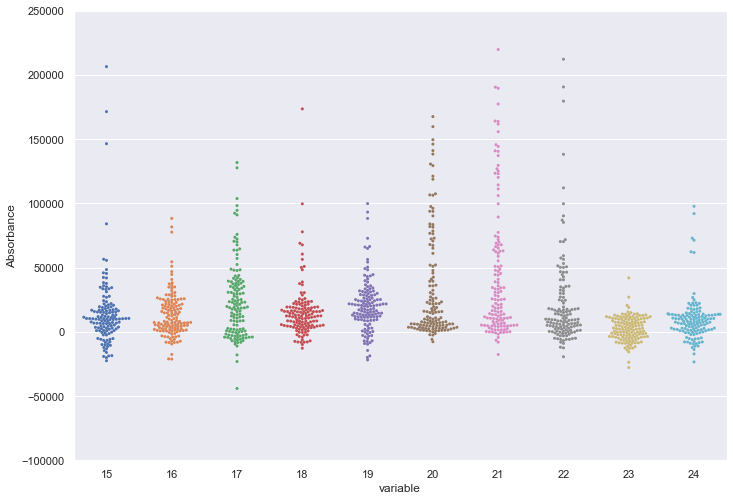

In [156]:
# Swarmplot for sanity check
import seaborn as sns

sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.swarmplot(x="variable", y="value", data=pd.melt(edge1.iloc[:,15:25]),
              size=3)
ax = plt.gca()
ax.set_ylim([-100000, 250000])
plt.ylabel("Absorbance")

In [74]:
control1.iloc[:,20].min()

-7152.667666121852

In [76]:
# Export to look at edge effect
edge1.to_csv("C:/FYP/Analysis/Excel analysis/No norm, average IgE/edge_adjusted/1_edge.csv",index=False)
edge2.to_csv("C:/FYP/Analysis/Excel analysis/No norm, average IgE/edge_adjusted/2_edge.csv",index=False)

In [157]:
next1 = edge1.copy(deep=True)
next2 = edge2.copy(deep=True)

## 4.1. Find cut-off based on absorbance

Find the optimum cut-off for absorbance such that the sensitisation cut-off accurately reflects the Der p, Per a and Bla g SPT results. In this case however, we won't use Mean + 2SD as the cut-off

In [158]:
# Import the required epi data
epi_df = pd.read_excel("MI_batch.xlsx")

def transform_id(row):
    return int(row["ID"][2:])
# df.loc[df["gender"] == "male", "gender"] = 1

epi_df["ID"] = epi_df.apply(transform_id, axis=1)

epi_df.loc[epi_df["Der p"] != 0, "Der p"] = 1
epi_df.loc[epi_df["Blo t"] != 0, "Blo t"] = 1
epi_df.loc[epi_df["Per a"] != 0, "Per a"] = 1
epi_df.loc[epi_df["Bla g"] != 0, "Bla g"] = 1

# Subset only the patients we screened
epi_df = epi_df[epi_df["ID"].isin(panel1["ID"])]
print(epi_df.shape)

# Print percentages of SPT positive for each allergen
print("Percentage with positive SPT:")
print("Der p: " + str(epi_df["Der p"].value_counts()[1] / epi_df.shape[0]))
print("Blo t: " + str(epi_df["Blo t"].value_counts()[1] / epi_df.shape[0]))
print("Per a: " + str(epi_df["Per a"].value_counts()[1] / epi_df.shape[0]))
print("Bla g: " + str(epi_df["Bla g"].value_counts()[1] / epi_df.shape[0]))
# print(f"{epi_df["Der p"].value_counts()[1]}")

(125, 12)
Percentage with positive SPT:
Der p: 0.688
Blo t: 0.688
Per a: 0.432
Bla g: 0.416


In [162]:
# Test on panel 1
adjust1 = edge1.copy(deep=True)
adjust2 = edge2.copy(deep=True)

cut_off = 5000 # This cut-off seems to work similar for both panel 1 and 2

# Der p should be index 20, Blo t - 22, Bla g - 23, Per a - 24, 
def sensitised(row):
    if row[24] > cut_off:
        return 1
    return 0

adjust1["Test sens"] = adjust1.apply(sensitised, axis=1)
print("Current allergen sensitisation rate: " + str(adjust1["Test sens"].value_counts()[1] / adjust1.shape[0]))

Current allergen sensitisation rate: 0.6222222222222222


From the cut-off we find, we determine the respective IgE cut-off, and adjust the dataset enough such that the IgE cut-off is = 1

In [163]:
ige_cutoff = m*cut_off + b

# Find out how much to increment cut_off by
# Given ige_cutoff = 1, what is cut_off?
endpoint = (1 - b) / m

print("New cut off should be: " + str(endpoint))
print("Increment entire dataset by: " + str(endpoint - cut_off))

for column in edge1.columns:
    edge1[column] = edge1[column].apply(lambda x: x + endpoint - cut_off)
for column in edge2.columns:
    edge2[column] = edge2[column].apply(lambda x: x + endpoint - cut_off)

New cut off should be: 8501.209123524532
Increment entire dataset by: 3501.2091235245316


In [164]:
next1 = edge1.copy(deep=True)
next2 = edge2.copy(deep=True)

## 5. Approximate sIgE level from absorbance based on average IgE standard curve

Apply the equation: IU = m * absorbance + b, and then divide by 100 to bring down the values (to the range that Prof Chew wants)

In [178]:
# For simplicity, we will use the combined IgE curve
sige_1 = next1.applymap(lambda x : (m*x + b) / 100)
sige_1.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135
0,-1.953715,-0.880667,0.048423,0.01,-0.510763,-0.315617,-0.512955,-2.353567,-1.296491,-1.880019,-1.313212,-1.200030,-0.464360,-0.260310,0.001554,0.256484,0.166819,-0.160603,-0.846148,-1.283450,1.142426,0.492076,0.307125,0.114717,-0.051921,-0.328169,-0.982014,-0.257255,-0.040754,0.061948,0.153136,0.293670,0.466082,0.367138,0.652580,0.545260,-0.440205,-0.265018,-0.517269,-0.265894,-0.383025,-0.519232,-0.427976,-0.555445,1.193822,0.375557,0.040029,0.285268,0.269725,-0.441085,0.511893,0.708291,0.599988,0.486255,-0.262703,-0.209694,-0.815025,-0.626089,-0.848441,-0.730471,-1.311750,-0.454345,-0.520636,-0.117460,0.248310,-0.575665,-0.928651,0.241238,-0.258831,0.172865,0.587931,0.447751,-0.285729,-0.426626,-0.992040,-1.144504,-0.761635,-0.333089,-0.233551,-0.156942,0.208615,0.431801,0.287267,0.526407,0.547255,0.564090,0.500396,0.538667,0.524155,0.381933,-0.685069,-0.935444,-1.060734,-0.915553,-0.672379,-0.245359,-0.106808,0.158457,0.485485,0.171867,0.367641,0.509643,0.031715,0.273968,0.509152,0.326297,0.372500,0.592445,-0.884139,-0.893442,-0.680263,-0.649790,-0.548633,-0.027832,0.081219,0.409622,0.411038,0.611229,0.631241,0.599194,0.508510,0.596503,0.534125,0.578790,0.574973,-0.049139,-0.630647,-0.209370,-0.356221,-0.144837,-0.007613,0.092597,0.173428,0.306762,0.423168,0.611659
1,-1.494863,-0.573220,-0.020193,0.01,-1.139529,-1.223387,-0.542258,-3.029166,-2.662996,-3.455942,-1.881824,-2.084209,-2.006931,-2.075270,-2.054010,-1.814770,-1.720151,-1.512526,-0.065037,-0.580990,0.402162,-0.354597,-0.458381,-1.022442,-0.141873,-0.004942,-0.804424,-0.428440,-0.663226,-1.958159,-1.191885,-1.254090,-1.458008,-0.969292,-0.206794,0.071400,0.862698,0.437908,-0.238566,0.034399,0.185639,-1.245241,0.115970,-0.048423,1.929687,1.262487,-1.365108,-1.635747,-1.251609,-1.562211,-1.033491,-0.507892,0.063280,0.416295,0.945385,-1.209497,-0.412491,0.699233,0.301412,-0.515270,-1.099165,-0.569685,-1.927220,-1.872055,-1.552990,-2.309021,-2.529514,-0.317551,-0.607090,0.092979,0.462830,0.562917,1.087853,0.651394,0.864757,0.909439,0.680247,0.324197,-0.184897,-0.528032,-1.452808,-1.222995,-1.009547,-0.615652,-0.056978,0.177449,0.651908,0.793243,0.900901,0.754073,1.391813,1.004546,0.911191,0.684156,0.544783,0.193278,0.345799,-0.195503,-0.153299,-0.469427,-0.322199,-0.076584,-0.172235,0.195760,0.555528,0.558707,0.705811,0.956515,1.100721,0.832143,0.649886,-0.012810,0.397842,0.667647,0.880708,0.664344,0.838845,0.643378,0.654522,0.744539,0.729490,0.906184,1.126516,1.065374,1.327886,0.880281,1.395959,1.364491,1.253928,1.284736,1.529993,1.378766,1.512516,1.469972,1.381455,1.389417
2,9.062102,3.931844,-0.204048,0.01,-1.417994,-1.219639,-1.649471,-2.777273,-2.568848,-3.526711,-2.364806,-2.170955,-1.484897,-1.194664,-0.785662,-0.127862,0.143371,0.764429,-0.858771,-1.563234,0.710864,0.030593,2.761839,0.241084,-0.348671,-0.379653,-0.569956,-0.555498,-0.175447,-0.059200,0.964765,0.828316,1.285556,1.176851,1.309732,1.791900,0.168534,0.094847,6.127188,2.981577,2.010398,0.780778,0.945928,-0.035047,2.165956,1.639819,-0.022877,0.213797,0.457592,1.941200,0.899587,1.546850,1.533572,2.612124,0.668404,8.863301,8.373761,2.491130,4.421812,2.609928,6.582810,-0.764791,1.558851,0.674530,1.340111,3.406292,6.764023,0.838515,3.929503,3.164736,2.325157,3.043832,1.386712,0.759936,3.772103,1.589459,-0.602290,-2.287130,-0.122093,0.402290,0.238547,0.895446,2.206374,0.959310,-0.004386,0.746656,1.483702,1.466469,3.628720,5.435079,0.888768,-0.133985,-0.561516,-1.076157,-0.928762,-0.704233,-0.308392,1.055281,0.496902,2.364466,2.321675,2.212635,3.160745,2.266047,1.438678,3.85135

In [167]:
# DONT RUN THIS AS IT WILL ADD A COLUMN WE DONT WANT
# Test if our method of adjusting was accurate
# Looks good!
def ige_sensitised(row):
    if row[20] > 1:
        return 1
    return 0

sige_1["Test sens"] = sige_1.apply(ige_sensitised, axis=1)
print("Current allergen sensitisation rate: " + str(sige_1["Test sens"].value_counts()[1] / sige_1.shape[0]))

Current allergen sensitisation rate: 0.7333333333333333


In [179]:
sige_2 = next2.applymap(lambda x : (m*x + b) / 100)
sige_2.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133
0,3.619046,0.708775,-0.130034,0.01,0.114607,-0.221699,0.286585,-0.011838,0.317284,-1.174325,0.389845,-0.413458,0.415618,0.706143,1.211868,1.584159,1.895500,1.587084,0.007946,0.112326,-0.666387,-0.762896,0.631518,-0.742787,-0.890428,0.322988,0.276052,-0.395255,-0.547823,-0.778273,0.332596,0.527268,0.800781,0.902904,1.280759,1.472631,-0.687307,-1.228034,0.603080,0.552217,0.991251,0.493024,0.858695,1.031576,-0.263127,-0.836818,-1.222211,-0.892118,-0.833527,-0.424594,-0.035998,-0.330913,0.129829,0.293588,0.591514,0.613949,0.695503,0.632855,0.990132,1.501229,1.812244,1.189778,-0.826372,-1.365149,-1.172665,-1.045938,-0.653265,-0.405722,0.112834,0.304939,0.671229,0.386430,0.697155,0.757388,1.000424,0.829740,0.846522,0.793079,0.970527,1.035044,-1.382488,1.049949,-0.817717,-0.038617,0.728007,0.373640,0.639869,0.717922,0.543388,0.633538,0.974600,0.697695,0.622684,0.977575,0.951809,1.034618,1.495181,1.421121,-0.889896,-0.835451,-0.519665,-0.169964,0.314786,0.405559,0.757075,0.603083,0.578980,0.696152,0.648355,0.684124,1.127457,0.750244,0.979598,0.797034,0.646182,1.788681,0.034723,3.962431,0.219269,1.060414,1.108159,0.715577,0.891908,0.626524,0.915407,0.867750,1.250339,0.874393,0.946863,1.103615,3.036071,1.361185,2.217126,1.806485
1,-0.692128,0.480436,0.524138,0.01,0.037503,-0.155719,0.831349,-0.122031,0.316390,-0.911654,0.799171,1.102547,1.707154,2.202009,2.423757,1.676717,1.947861,1.731436,0.044760,-1.379659,-0.545869,-1.689442,-1.380101,-0.888196,-0.498467,1.539102,1.184465,0.867952,0.128595,-0.313732,-0.079244,-0.114528,0.290121,0.126290,0.558013,1.768646,-1.096076,-1.358341,1.237436,1.372434,1.338506,1.528883,1.625626,1.906501,-0.526740,-1.486795,-0.861622,-1.092742,-0.582633,-0.374638,0.611008,0.875856,0.887045,1.070318,0.941206,1.146954,1.200407,1.174044,1.108007,1.773683,1.715334,2.645166,-0.789769,-1.139766,-0.606422,-0.370238,0.978953,1.168652,1.407565,1.584805,1.486324,1.541155,1.284077,1.807734,1.023239,1.282928,1.963926,1.909962,2.672744,3.097467,0.036139,-1.364801,0.450494,0.654382,0.974278,1.713848,1.929743,1.905653,1.864747,1.558750,1.367568,1.459035,1.709607,1.899466,2.346911,2.802821,3.264645,4.049839,0.657400,0.708153,1.343001,1.560001,2.074297,1.926710,2.083193,2.150756,2.248535,1.803276,2.124161,1.999651,1.654162,2.140845,2.622151,2.796871,3.481167,3.563826,2.672824,0.763262,2.621095,1.982242,2.315214,2.726304,2.778751,2.790966,2.967535,3.008982,2.602033,2.932231,2.935285,2.364599,1.609347,3.490741,3.637483,4.468236
2,-1.722859,-0.705828,-0.106803,0.01,-0.005680,0.049517,-4.295729,-3.135494,-2.780254,-1.790865,-1.249477,-0.491860,-0.340772,-0.427801,-0.670376,-0.776690,-1.107483,-1.708118,-0.340291,-0.464905,2.600279,2.619722,0.214686,0.684882,0.790424,0.170196,0.146507,0.412559,0.612616,0.699088,-0.226482,-0.327260,-0.492018,-0.667545,-0.956654,-0.910271,0.431347,0.562349,0.004878,-0.019389,0.027873,-0.066088,-0.323549,-0.691501,-0.300979,0.250986,0.560679,1.004113,1.244000,1.342675,1.003165,1.007443,0.421482,0.349811,0.322691,0.165248,0.126177,0.135356,-0.012939,-0.190325,-0.538653,-0.853594,-0.306317,0.370676,0.589645,0.526281,0.719124,0.708798,0.487735,0.398943,0.254661,0.294589,0.246631,0.279089,-0.171717,-0.036003,0.067461,-0.196404,-0.456904,-1.189679,-0.131477,-0.529820,0.159792,0.209817,0.139555,0.346676,0.267272,0.168061,0.298833,0.356402,0.652160,0.228493,0.174718,0.081700,-0.165929,-0.306724,-0.676290,-1.079412,-0.622814,-0.243988,-0.288781,-0.562219,-0.431732,-0.264225,-0.360378,-0.152268,-0.034607,0.096553,0.062348,-0.145377,-0.357782,-0.359701,-0.332211,-0.606275,-1.005845,-1.777308,-

#### For non-normalised combined dataset, we take the equation from excel instead

In [ ]:
# Equation for this is a polynomial
m2 = 0.000000105465
m = -0.003533484483
b = 25.417313157442
sige_1 = sub1.applymap(lambda x: m2 * x ** 2 + m*x + b)
sige_2 = sub2.applymap(lambda x: m2 * x ** 2 + m*x + b)
sige_1.head()

In [ ]:
import math
# Exponential for average IgE
a = 11.0026648736
b = 0.0000415981
sige_1 = sub1.applymap(lambda x: a * math.exp(b * x))
sige_2 = sub2.applymap(lambda x: a * math.exp(b * x))
sige_1.head()

In [ ]:
# Exponential for batch 090322
a = 10.336875365302
b = 0.000036487155
sige_1 = sub1.applymap(lambda x: a * math.exp(b * x))
sige_2 = sub2.applymap(lambda x: a * math.exp(b * x))
sige_1.head()

In [ ]:
# Exponential for batch 120322
a = 9.513681550566
b = 0.000038529260
sige_1 = sub1.applymap(lambda x: a * math.exp(b * x))
sige_2 = sub2.applymap(lambda x: a * math.exp(b * x))
sige_1.head()

## 5.1. Approximate based on batch blank IgE curve

In [ ]:
blank1_ige_df = panel1[panel1["ID"] == "B"].iloc[:,9:18]
blank1_pbs = panel1[panel1["ID"] == "B"].iloc[:,6]
blank1_ige = blank1_ige_df.mean(axis=0) - blank1_pbs.mean(axis=0)
# Plot scatterplot
plt.scatter(blank1_ige, ige_level)

# Add trendline
m1, b1, r, p_value, se = stats.linregress(blank1_ige, ige_level)
plt.plot(blank1_ige, m1*blank1_ige + b1)

plt.ylabel("IgE concentration")
plt.xlabel("Absorbance")

# Print equation and R2
print(f"Equation: y = {m1}*x + {b1}")
print(f"R2: {r ** 2}")

In [ ]:
blank1_ige_df

In [ ]:
blank2_ige_df = panel2[panel2["ID"] == "B"].iloc[:,9:18]
blank2_pbs = panel2[panel2["ID"] == "B"].iloc[:,6]
blank2_ige = blank2_ige_df.mean(axis=0) - blank2_pbs.mean(axis=0)
# Plot scatterplot
plt.scatter(blank2_ige, ige_level)

# Add trendline
m2, b2, r, p_value, se = stats.linregress(blank2_ige, ige_level)
plt.plot(blank2_ige, m2*blank2_ige + b2)

plt.ylabel("IgE concentration")
plt.xlabel("Absorbance")

# Print equation and R2
print(f"Equation: y = {m2}*x + {b2}")
print(f"R2: {r ** 2}")

In [ ]:
# Take out the first 3 columns, and then apply the formula
batchige1 = sub1.applymap(lambda x: m1*x + b1)
batchige2 = sub2.applymap(lambda x: m2*x + b2)
batchige1.head()

In [ ]:
# Export
batchige1.to_csv("Processing/raw_converted1.csv", index=False)
batchige2.to_csv("Processing/raw_converted2.csv", index=False)

In [ ]:
# Transform to range(0, 1000)
# Alter the values
for column in batchige1:
    # If below 0, set to 0
    batchige1.loc[batchige1[column] < 0, column] = 0
    # If above 1000, set to 1000
    batchige1.loc[batchige1[column] > 1000, column] = 1000

for column in batchige2:
    # If below 0, set to 0
    batchige2.loc[batchige2[column] < 0, column] = 0
    # If above 1000, set to 1000
    batchige2.loc[batchige2[column] > 1000, column] = 1000

## 6. Add them all together to create the final dataset

- Sort by id
- Compare the IU for the controls (just to see)
- Add the allergens from panel 2 to panel 1 by index
- Add in the names
- Export

Sort by id

In [180]:
final_1 = sige_1.copy(deep=True)
final_2 = sige_2.copy(deep=True)

# Add back batch, panel, ID
final_1.insert(0, "Batch", panel1["Batch"])
final_1.insert(0, "Panel", panel1["Panel"])
final_1.insert(0, "ID", panel1["ID"])
final_2.insert(0, "Batch", panel2["Batch"])
final_2.insert(0, "Panel", panel2["Panel"])
final_2.insert(0, "ID", panel2["ID"])

# Remove blank
final_1 = final_1[final_1["ID"] != "B"]
final_2 = final_2[final_2["ID"] != "B"]

# Change ID type to int
final_1["ID"] = pd.to_numeric(final_1["ID"])
final_2["ID"] = pd.to_numeric(final_2["ID"])

# Sort by ID
final_1 = final_1.sort_values("ID").reset_index(drop=True)
final_2 = final_2.sort_values("ID").reset_index(drop=True)

final_1.head()

,ID,Panel,Batch,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135
0,1,1,150222-CSV,-1.097396,-0.733835,-0.093562,0.01,-0.853471,-0.978381,-2.381686,-3.050749,-2.254322,-2.405754,-1.239627,-1.417003,-1.162185,-1.384159,-1.585191,-1.386305,-1.730191,-1.855242,-0.022991,0.060144,0.462012,0.212695,0.332979,0.454364,0.325848,0.410197,0.503529,0.196145,-0.049028,-0.360585,-0.490783,-0.765862,-0.553009,-0.665289,-0.503207,-0.649283,0.812176,0.609927,0.998639,0.558884,0.545738,0.632092,0.840612,0.349561,1.221640,0.481629,-0.345772,-0.500030,-0.635356,-0.759998,-0.263306,-0.235961,-0.191729,-0.165127,0.782684,1.289993,1.036780,0.940823,1.055961,0.907153,0.068193,0.229222,-0.489850,-0.957283,-0.677425,-0.977146,-1.224462,-0.231583,-0.428622,0.055679,0.160562,-0.059873,1.065126,1.154923,1.022763,1.076019,1.061228,0.889912,0.698529,0.333969,0.050286,-0.255367,-0.236437,-0.063600,0.108020,0.314933,0.511808,0.573387,0.477043,0.195038,1.078425,1.145103,1.169210,0.997462,0.865015,0.685881,0.692882,0.447526,0.487295,0.093261,0.504171,0.319329,0.356458,0.323025,0.625709,0.392340,0.369477,0.308327,0.780169,0.899107,0.733814,0.636637,0.724351,0.931039,0.885822,0.909498,1.021322,0.868092,0.903675,0.943887,0.794776,0.872237,1.022556,0.982190,0.605039,-0.227388,0.660478,0.912609,0.971005,1.100721,1.132107,1.232660,1.224993,1.363289,1.172723,1.076749
1,2,1,150222-CSV,9.062102,3.931844,-0.204048,0.01,-1.417994,-1.219639,-1.649471,-2.777273,-2.568848,-3.526711,-2.364806,-2.170955,-1.484897,-1.194664,-0.785662,-0.127862,0.143371,0.764429,-0.858771,-1.563234,0.710864,0.030593,2.761839,0.241084,-0.348671,-0.379653,-0.569956,-0.555498,-0.175447,-0.059200,0.964765,0.828316,1.285556,1.176851,1.309732,1.791900,0.168534,0.094847,6.127188,2.981577,2.010398,0.780778,0.945928,-0.035047,2.165956,1.639819,-0.022877,0.213797,0.457592,1.941200,0.899587,1.546850,1.533572,2.612124,0.668404,8.863301,8.373761,2.491130,4.421812,2.609928,6.582810,-0.764791,1.558851,0.674530,1.340111,3.406292,6.764023,0.838515,3.929503,3.164736,2.325157,3.043832,1.386712,0.759936,3.772103,1.589459,-0.602290,-2.287130,-0.122093,0.402290,0.238547,0.895446,2.206374,0.959310,-0.004386,0.746656,1.483702,1.466469,3.628720,5.435079,0.888768,-0.133985,-0.561516,-1.076157,-0.928762,-0.704233,-0.308392,1.055281,0.496902,2.364466,2.321675,2.212635,3.160745,2.266047,1.438678,3.851356,3.770285,2.736384,1.644716,0.211628,0.080753,2.469379,4.490485,0.230117,0.700670,0.898339,1.395678,1.314127,2.597860,2.165019,2.263289,1.850978,1.955482,1.754849,1.857736,9.030354,1.397135,0.353012,0.677501,0.672519,0.463694,0.721699,0.895843,0.924071,1.769653,1.319436
2,4,1,150222-CSV,-1.513208,-1.039074,-0.136012,0.01,-1.451574,-1.637073,-0.059543,-1.653189,-1.488076,-2.254392,-2.435229,-2.619888,-2.033239,-1.765931,-1.785770,-1.200136,-0.786379,-0.188413,-0.842490,-1.643466,-0.136186,-0.758102,-0.335222,-0.502188,-0.218968,-0.630791,-0.651847,-0.904331,-1.110397,-1.242315,-0.973113,-0.829543,-0.517222,0.279461,0.764649,1.881909,-0.097797,-1.006041,0.509293,-0.501193,-0.579843,-0.621287,-0.659300,-1.275542,2.614450,2.438172,-1.252656,-1.306015,-0.855038,-1.095834,-0.010346,0.133328,1.010524,1.991362,0.296739,3.372783,1.968026,-0.354552,-0.561568,-1.278313,-1.682980,-1.685268,-1.749529,-1.604022,-1.016166,-1.588019,-1.670628,0.203182,-0.104853,0.705187,1.367013,1.710790,0.579184,0.258055,-0.206847,-1.109820,-1.364023,-1.938984,-1.728221,-3.481165,-1.279481,-0.945660,-0.505956,-0.273070,0.260247,0.467339,0.744078,1.117205,1.373134,1.961372,0.814068,0.097287,-0.573013,-1.352068,-1.629804,-1.937259,-1.174804,-1.650204,-0.574631,-0.476078,0.056004,0

Compare controls

In [ ]:
# Compare all common controls, except IgE and seafood crude
# which are the dust mite allergens, dust mite and cockroach crudes

# For each id
for idx in final_1["ID"]:
    print(f"ID: {idx}")
    for i in range(18,25):
        # index = i+3 # Skip first 3 columns
        p1 = final_1.iloc[:,i].loc[final_1["ID"] == idx]
        p2 = final_2.iloc[:,i].loc[final_2["ID"] == idx]
        
        print(f"  {p1.to_string()} VS {p2.to_string()}")

<AxesSubplot:xlabel='Control', ylabel='sIgE'>

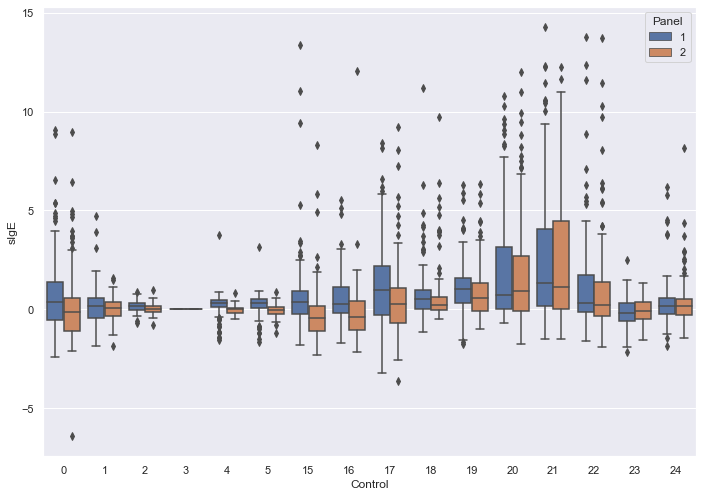

In [182]:
# Visualise the group difference with boxplot
# See if combined or separate IgE curve is better
import seaborn as sns

# control_df = pd.concat([final_1, final_2]).iloc[:,:28]
control_df = pd.concat([final_1.iloc[:,:28], final_2.iloc[:,:28]])
# Remove IgE standards - 9 to 17
control_df.drop(control_df.columns[9:18], axis=1, inplace=True)
# Drop ID and Batch for simplicity
control_df.drop(columns=["ID", "Batch"], inplace=True)
control_long = pd.melt(control_df, "Panel", 
                       var_name="Control", value_name="sIgE")

sns.boxplot(x="Control", y="sIgE", hue="Panel", 
            data=control_long)

# Set max = 1000
# plt.ylim(-500, 1000)

# Set range to 3000, 4000
# plt.ylim(3000, 4000)

Some seem to be quite different. 15, 16, and 17 are generally lower in panel 2 (though they will just get fixed to 0 if negative). 21, 22 and 23 seem to be slight higher in panel 2 too.

Now we add allergens from panel 2 to 1

DISCLAIMER: This is a raw add. There is no adjusting of values or anything

In [183]:
# Add the 28th sample ownwards (index 27, 30 in df)
final_df = pd.concat([final_1, final_2.iloc[:,30:]], axis=1)
final_df.head()

,ID,Panel,Batch,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133
0,1,1,150222-CSV,-1.097396,-0.733835,-0.093562,0.01,-0.853471,-0.978381,-2.381686,-3.050749,-2.254322,-2.405754,-1.239627,-1.417003,-1.162185,-1.384159,-1.585191,-1.386305,-1.730191,-1.855242,-0.022991,0.060144,0.462012,0.212695,0.332979,0.454364,0.325848,0.410197,0.503529,0.196145,-0.049028,-0.360585,-0.490783,-0.765862,-0.553009,-0.665289,-0.503207,-0.649283,0.812176,0.609927,0.998639,0.558884,0.545738,0.632092,0.840612,0.349561,1.221640,0.481629,-0.345772,-0.500030,-0.635356,-0.759998,-0.263306,-0.235961,-0.191729,-0.165127,0.782684,1.289993,1.036780,0.940823,1.055961,0.907153,0.068193,0.229222,-0.489850,-0.957283,-0.677425,-0.977146,-1.224462,-0.231583,-0.428622,0.055679,0.160562,-0.059873,1.065126,1.154923,1.022763,1.076019,1.061228,0.889912,0.698529,0.333969,0.050286,-0.255367,-0.236437,-0.063600,0.108020,0.314933,0.511808,0.573387,0.477043,0.195038,1.078425,1.145103,1.169210,0.997462,0.865015,0.685881,0.692882,0.447526,0.487295,0.093261,0.504171,0.319329,0.356458,0.323025,0.625709,0.392340,0.369477,0.308327,0.780169,0.899107,0.733814,0.636637,0.724351,0.931039,0.885822,0.909498,1.021322,0.868092,0.903675,0.943887,0.794776,0.872237,1.022556,0.982190,0.605039,-0.227388,0.660478,0.912609,0.971005,1.100721,1.132107,1.232660,1.224993,1.363289,1.172723,1.076749,0.075952,0.051187,0.156720,-0.015686,-0.060733,-0.044369,-0.315912,-0.580576,-0.944178,0.396418,0.395809,0.114991,0.059441,0.039594,-0.115797,-0.313980,-0.602085,-0.135291,0.261065,0.360473,0.321338,0.321582,0.194667,0.266085,0.398888,0.413705,0.455633,0.489274,0.450605,0.461312,0.358367,0.168011,-0.060782,-0.339532,-0.549845,-0.054652,0.360909,0.402364,0.278390,0.457551,0.489515,0.531373,0.568690,0.537662,0.585424,0.573601,0.586544,0.039449,0.112787,0.295164,-0.001632,-0.268361,-0.797701,-0.049046,-0.347746,0.326147,0.488669,0.390547,0.568460,0.613418,0.590639,0.568588,0.548342,0.658636,0.418443,0.322719,0.327492,0.057050,-0.133776,-0.428591,-0.808754,-0.215494,0.208145,0.322189,0.445483,0.479891,0.454150,0.336830,0.384137,0.316337,0.322588,0.340923,0.099829,-0.149650,-0.068515,-0.040095,-0.243101,-0.584271,-1.374597,-0.560688,-0.995724,-0.248516,-0.127910,-0.126120,-0.046768,-0.087690,-0.105779,-0.156909,-0.238642,-0.139686,-0.343432,-0.467450,-0.735091,-0.618637,-0.901311,-0.984302,-1.472121
1,2,1,150222-CSV,9.062102,3.931844,-0.204048,0.01,-1.417994,-1.219639,-1.649471,-2.777273,-2.568848,-3.526711,-2.364806,-2.170955,-1.484897,-1.194664,-0.785662,-0.127862,0.143371,0.764429,-0.858771,-1.563234,0.710864,0.030593,2.761839,0.241084,-0.348671,-0.379653,-0.569956,-0.555498,-0.175447,-0.059200,0.964765,0.828316,1.285556,1.176851,1.309732,1.791900,0.168534,0.094847,6.127188,2.981577,2.010398,0.780778,0.945928,-0.035047,2.165956,1.639819,-0.022877,0.213797,0.457592,1.941200,0.899587,1.546850,1.533572,2.612124,0.668404,8.863301,8.373761,2.491130,4.421812,2.609928,6.582810,-0.764791,1.558851,0.674530,1.340111,3.406292,6.764023,0.838515,3.929503,3.164736,2.325157,3.043832,1.386712,0.759936,3.772103,1.589459,-0.602290,-2.287130,-0.122093,0.402290,0.238547,0.895446,2.206374,0.959310,-0.004386,0.746656,1.483702,1.466469,3.628720,5.435079,0.888768,-0.133985,-0.561516,-1.076157,-0.928762,-0

Change header to the correct allergens

In [184]:
panel = pd.read_excel("Panel.xlsx")
pd.options.display.max_columns = None
final_df2 = final_df.set_axis(panel.columns, axis=1, inplace=False)

final_df2.head()

,ID,Panel,Batch,BSA,BB (with Urea),BB (without Urea),PBS,PBS + Glycerol,pET32 (a) vector,IgE 1000,IgE 500,IgE 250,IgE 125,IgE 62.5,IgE 31.25,IgE 15.625,IgE 7.8125,IgE 3.90625,Der p 10,Der p 20,Der f 10,Blo t 10,Blo t 20,Der p,Der f,Blo t,Bla g,Per a,Grey Prawn,Mussel,Squid,Soy,Peas,Mung beans,Faba beans,Shiitake mushroom,Chickpea,Onion,Potato,Barley,Carrot,Brown rice,Basmati rice,White rice,Jasmine rice,Sushi rice,Wheat germ,Chicken breast,Soy #,Peas #,Mung beans #,Faba beans #,Shiitake #,Chickpea #,Onion #,Potato #,Barley #,Carrot #,Brown rice #,Basmati rice #,White rice #,Jasmine rice #,Sushi rice #,Wheat germ #,Chicken breast #,Q Garlic and Herb Fillets,Q Southern Fried Burgers,Q Hot and Spicy Burger,Q Brilliant Burgers,Q Garlic and Mushroom Escalope,Q Swedish style Balls,Q Crispy Nuggets,Q Sausages,Q Vegan Fillets,Q Southern Fried Bites,Q Mince,Q Pieces,F No-Meatballs,F The Big Fry Burger,F Fish Style Fillets,F Mediterranean Style Artisan Sausage,F Breakfast Bangers,F Golden Schnitzel,F Chicken Strips,F Spiced Burger,F Braai Sausages,F Chicken Nuggets,F Chicken Burgers,F Traditional Sausages,F Rice Protein and Chia Nuggets,F Traditional Burgers,F Soy and Flaxseed Schnitzels,F Spicy Sausages,F Quinoa and Brown Rice Burgers,F Battered Prawn Style Pieces,F Thick Cut Chunky Strips,F Mince,MM Burger,MM Hotdog,MM Meatballs,H Mediterranean chunks,Cultured meat,Q Garlic and Herb Fillets #,Q Southern Fried Burgers #,Q Hot and Spicy Burger #,Q Brilliant Burgers #,Q Garlic and Mushroom Escalope #,Q Swedish style Balls #,Q Crispy Nuggets #,Q Sausages #,Q Vegan Fillets #,Q Southern Fried Bites #,Q Mince #,Q Pieces #,F No-Meatballs #,F The Big Fry Burger #,F Fish Style Fillets #,F Mediterranean Style Artisan Sausage #,F Breakfast Bangers #,F Golden Schnitzel #,F Chicken Strips #,F Spiced Burger #,F Braai Sausages #,F Chicken Nuggets #,F Chicken Burgers #,F Traditional Sausages #,F Rice Protein and Chia Nuggets #,F Traditional Burgers #,F Soy and Flaxseed Schnitzels #,F Spicy Sausages #,F Quinoa and Brown Rice Burgers #,F Battered Prawn Style Pieces #,F Thick Cut Chunky Strips #,F Mince #,MM Burger #,MM Hotdog #,MM Meatballs #,H Mediterranean chunks #,Cultured meat #,BSF-WT P,BSF-WT PKM,BSF-WT M<P,BSF Tropomyosin 1,BSF Tropomyosin 2,BSF Arginine kinase,TE Tropomyosin 1,SGC Arginine kinase,BSF-WT CF70,BSF-WT COH,BSF-WT SBM,NC11,NC15,BSF-WT CF70 #,BSF-WT PKM #,BSF-WT MIX1 #,BSF-WT COH #,BSF-WT SBM #,BSF-WT OKA #,BSF-WT P #,BSF-D PKM #,BSF-D MIX1 #,BSF-D COH #,BSF-D M #,BSF-D NUS #,NC10 #,NC11 #,NC15 #,AF Chik'n Nugget,AF Chik'n Burger,v Classic Burger,v Chicken Burgers,v Bacon Bits,v Meatballs,v Mince,E Veg Ku Loh Meat,G Teriyaki Chick'N Strips,G Vegetarian Crabless cakes,S Mince,S Chicken style pieces,S Meat Burger,L Vegetarian Sausages,L Red Onion and Rosemary Sausages,B Mince,B Burger,B Original Sausage,B Italian Sausage,Y Luncheon meat,Y Mince meat,OM All Purpose,OM Strips,OM Luncheon,BRM Soy protein,TS Pea protein,TS Brown rice protein,O Chocolate plant protein powder,C Cricket protein powder,N Cricket flour,AIFS Cricket flour,SG Canned BSF,SG Dried BSF,SG Dried Crickets,IFT Dried BSF Larvae,Insectta BSF meal,AF Chik'n Nugget #,AF Chik'n Burger #,v Classic Burger #,v Chicken Burgers #,v Bacon Bits #,v Meatballs #,v Mince #,E Veg Ku Loh Meat #,G Teriyaki Chick'N Strips #,G Vegetarian Crabless cakes #,S Mince #,S Chicken style pieces #,S Meat Burger #,L Vegetarian Sausages #,L Red Onion and Rosemary Sausages #,B Mince #,B Burger #,B Original Sausage #,B Italian Sausage #,Y Luncheon meat #,Y Mince meat #,OM All Purpose #,OM Strips #,OM Luncheon #,BRM Soy protein #,TS Pea protein #,TS Brown rice protein #,O Chocolate plant protein powder #,C Cricket protein powder #,N Cricket flour #,AIFS Cricket flour #,SG Canned BSF #,SG Dried BSF #,SG Dried Crickets #,IFT Dried BSF Larvae #,Insectta BSF meal #,BSF-D M<P,BSF-WT OKA,BSF-D M,BSF-D PKM,BSF-D NUS,BSF-D COH,NC10
0,1,1,150222-CSV,-1.097396,-0.733835,-0.093562,0.01,-0.853471,-0.978381,-2.38168

Force values above 1000 to 1000, and values below 0 to 0

* For now we ignore this *

In [ ]:
# Alter the values
for column in final_df2:
    if column in ["ID", "Batch", "Panel"]:
        continue
    # If below 0, set to 0
    final_df2.loc[final_df2[column] < 0, column] = 0
    # If above 1000, set to 1000
    # final_df2.loc[final_df2[column] > 1000, column] = 1000

final_df2.head()

In [185]:
# Export the final dataframe
final_df2.to_csv("Excel analysis/No norm, average IgE/linear_final.csv", index=False)